### Q1 1.2 
#### Implementation from Scratch

In [30]:
import numpy as np

def generate_data(sigma, n_samples=100):
    # Means for each cluster
    means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]
    # Covariance matrices for each cluster
    covariances = [sigma * np.array([[2, 0.5], [0.5, 1]]),
                   sigma * np.array([[1, -0.5], [-0.5, 2]]),
                   sigma * np.array([[1, 0], [0, 2]])]

    # Generate samples for each cluster
    X = np.vstack([np.random.multivariate_normal(mean, cov, size=n_samples) for mean, cov in zip(means, covariances)])
    # Generate labels for each cluster
    y = np.concatenate([[i]*n_samples for i in range(len(means))])

    return X, y


In [31]:
# K-means implementation
def kmeans(X, k, max_iters=100, n_init=10):
    best_inertia = np.inf
    best_centers = None
    best_labels = None
    
    for _ in range(n_init):
        # Initialize centers
        centers = init_centers(X, k)
        
        for _ in range(max_iters):
            # Assign clusters
            labels = assign_clusters(X, centers)
            # Compute new centers
            new_centers = compute_centers(X, labels, k)
            
            # Check for convergence
            if np.allclose(centers, new_centers):
                break
            centers = new_centers
        
        # Compute inertia (objective function)
        inertia = compute_inertia(X, centers, labels)
        
        if inertia < best_inertia:
            best_inertia = inertia
            best_centers = centers
            best_labels = labels
    
    return best_centers, best_labels

# Helper functions for K-means
def init_centers(X, k):
    indices = np.random.choice(X.shape[0], size=k, replace=False)
    centers = X[indices]
    return centers

def assign_clusters(X, centers):
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    return np.argmin(distances, axis=1)

def compute_centers(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def compute_inertia(X, centers, labels):
    return sum(np.linalg.norm(X[labels == i] - centers[i])**2 for i in range(centers.shape[0]))


In [32]:
# GMM implementation
def gmm(X, k, max_iters=100, n_init=10):
    best_score = -np.inf
    best_params = None
    
    for _ in range(n_init):
        # Initialize parameters
        weights = np.ones(k) / k
        means = init_centers(X, k)
        covariances = [np.cov(X.T) for _ in range(k)]
        
        for _ in range(max_iters):
            # E-step
            responsibilities = e_step(X, weights, means, covariances)
            # M-step
            weights, means, covariances = m_step(X, responsibilities, k)
            
            # Compute log likelihood
            score = log_likelihood(X, weights, means, covariances)
            
            if score > best_score:
                best_score = score
                best_params = (weights, means, covariances)
    
    return best_params, best_score

# Helper functions for GMM
def e_step(X, weights, means, covariances):
    r = np.zeros((X.shape[0], len(weights)))
    for k in range(len(weights)):
        r[:, k] = weights[k] * multivariate_normal(mean=means[k], cov=covariances[k]).pdf(X)
    r /= r.sum(axis=1, keepdims=True)
    return r

def m_step(X, r, num_clusters):
    Nk = r.sum(axis=0)
    weights = Nk / X.shape[0]
    means = np.dot(r.T, X) / Nk[:, None]
    covariances = []
    for cluster in range(num_clusters):
        diff = X - means[cluster]
        covariances.append(np.dot(r[:, cluster] * diff.T, diff) / Nk[cluster])
    return weights, means, covariances

def log_likelihood(X, weights, means, covariances):
    total = 0
    for k in range(len(weights)):
        total += weights[k] * multivariate_normal(mean=means[k], cov=covariances[k]).pdf(X)
    return np.sum(np.log(total))


In [33]:
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment

# This function computes the K-means objective
def kmeans_objective(X, centers, labels):
    distances = np.linalg.norm(X - centers[labels], axis=1)
    return np.sum(distances ** 2)

# This function computes the best matching of predicted labels to true labels
def cluster_accuracy(true_labels, pred_labels):
    size = max(true_labels.max(), pred_labels.max()) + 1
    w = np.zeros((size, size), dtype=np.int64)
    for i in range(true_labels.size):
        w[true_labels[i], pred_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return w[row_ind, col_ind].sum() / true_labels.size


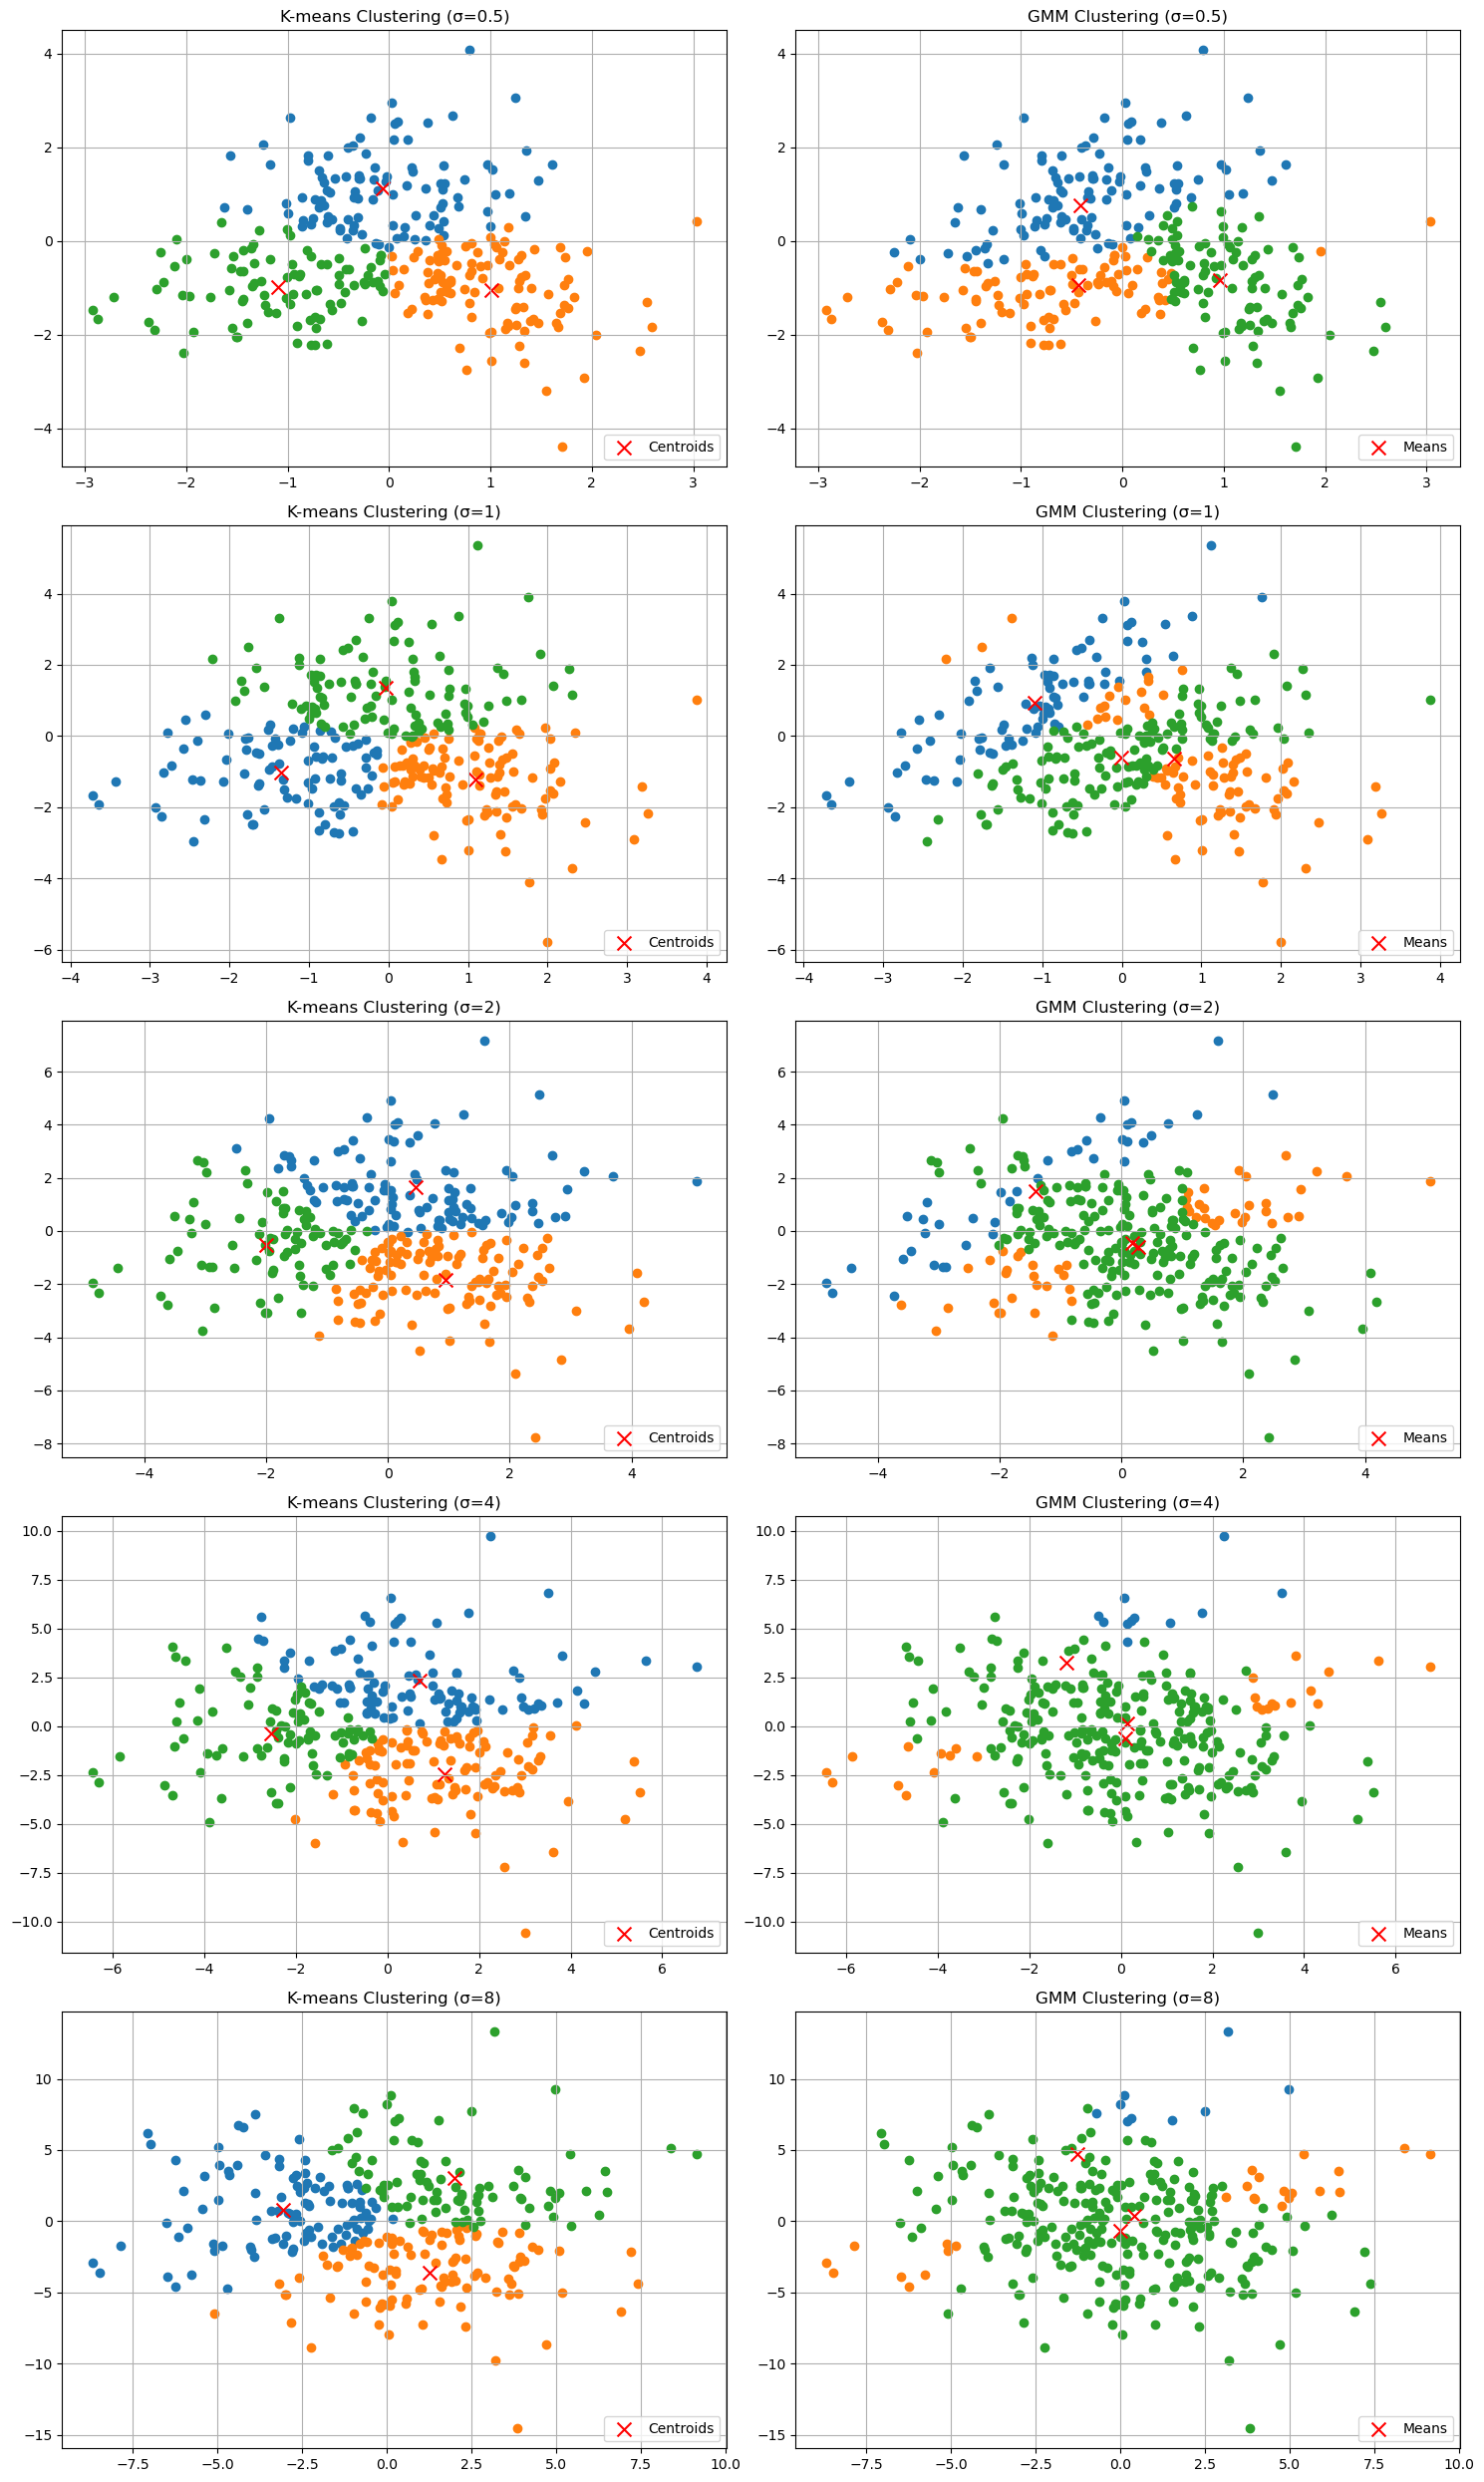

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming generate_data, kmeans, kmeans_objective, gmm, e_step, and cluster_accuracy functions are defined elsewhere

# List of sigma values to iterate over
sigmas = [0.5, 1, 2, 4, 8]

# Initialize lists to store metrics
kmeans_objectives = []
gmm_objectives = []
kmeans_accuracies = []
gmm_accuracies = []

# Define the figure size
plt.figure(figsize=(15, len(sigmas) * 5))

for i, sigma in enumerate(sigmas):
    # Generate synthetic data
    X, true_labels = generate_data(sigma)

    # Run K-means
    centers, kmeans_labels = kmeans(X, k=3)
    kmeans_obj = kmeans_objective(X, centers, kmeans_labels)
    kmeans_acc = cluster_accuracy(true_labels, kmeans_labels)

    # Store the K-means results
    kmeans_objectives.append(kmeans_obj)
    kmeans_accuracies.append(kmeans_acc)

    # Plot K-means clusters
    plt.subplot(len(sigmas), 2, 2*i + 1)  # Determine the subplot index for K-means
    for cluster in range(3):
        plt.scatter(X[kmeans_labels == cluster, 0], X[kmeans_labels == cluster, 1])
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', s=100, label='Centroids')
    plt.title(f'K-means Clustering (σ={sigma})')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Run GMM
    (weights, means, covariances), gmm_score = gmm(X, k=3)
    gmm_labels = np.argmax(e_step(X, weights, means, covariances), axis=1)
    gmm_obj = -gmm_score  # Since the score is negative log likelihood, we take its negative for objective
    gmm_acc = cluster_accuracy(true_labels, gmm_labels)

    # Store the GMM results
    gmm_objectives.append(gmm_obj)
    gmm_accuracies.append(gmm_acc)

    # Plot GMM clusters
    plt.subplot(len(sigmas), 2, 2*i + 2)  # Determine the subplot index for GMM
    for cluster in range(3):
        plt.scatter(X[gmm_labels == cluster, 0], X[gmm_labels == cluster, 1])
    plt.scatter(means[:, 0], means[:, 1], color='red', marker='x', s=100, label='Means')
    plt.title(f'GMM Clustering (σ={sigma})')
    plt.legend(loc='lower right')
    plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Sigma     K-means Objective   K-means Accuracy    GMM Objective       GMM Accuracy        
------------------------------------------------------------------------------------------
0.5       301.11              0.81                903.12              0.79                
1         512.99              0.71                1039.11             0.56                
2         913.38              0.55                1198.76             0.42                
4         1686.95             0.50                1377.80             0.39                
8         3208.87             0.40                1571.13             0.39                


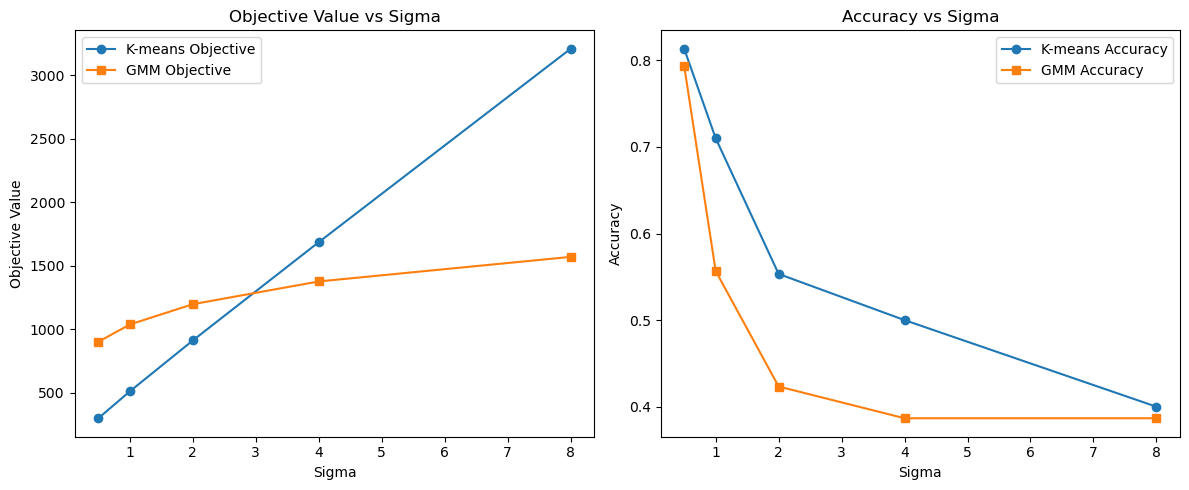

In [40]:
#Print data:
# Print the table header
print(f"{'Sigma':<10}{'K-means Objective':<20}{'K-means Accuracy':<20}{'GMM Objective':<20}{'GMM Accuracy':<20}")
print('-' * 90)  # Print a line to separate headers from the data

# Print the data rows
for i, sigma in enumerate(sigmas):
    print(f"{sigma:<10}{kmeans_objectives[i]:<20.2f}{kmeans_accuracies[i]:<20.2f}{gmm_objectives[i]:<20.2f}{gmm_accuracies[i]:<20.2f}")
  
# Plot for K-means and GMM 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot K-means and GMM objectives
ax1.plot(sigmas, kmeans_objectives, label='K-means Objective', marker='o')
ax1.plot(sigmas, gmm_objectives, label='GMM Objective', marker='s')
ax1.set_xlabel('Sigma')
ax1.set_ylabel('Objective Value')
ax1.set_title('Objective Value vs Sigma')
ax1.legend()

# Plot K-means and GMM accuracies
ax2.plot(sigmas, kmeans_accuracies, label='K-means Accuracy', marker='o')
ax2.plot(sigmas, gmm_accuracies, label='GMM Accuracy', marker='s')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Sigma')
ax2.legend()


# Show the plot
plt.tight_layout()
plt.show()

### Q2 -> 2.3
#### PCA implementation for BuggyPCA, DemeanedPCA, NormalizedPCA, DRO

In [48]:
import numpy as np
from numpy.linalg import svd
from sklearn.preprocessing import StandardScaler

def buggy_pca(X, d):
    U, S, Vt = svd(X, full_matrices=False)
    Z = np.dot(X, Vt[:d].T)
    reconstruction = np.dot(Z, Vt[:d])
    return Z, Vt[:d], reconstruction

def demeaned_pca(X, d):
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = svd(X_demeaned, full_matrices=False)
    Z = np.dot(X_demeaned, Vt[:d].T)
    reconstruction = np.dot(Z, Vt[:d]) + mean_X
    return Z, (Vt[:d], mean_X), reconstruction

def normalized_pca(X, d):
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    U, S, Vt = svd(X_normalized, full_matrices=False)
    Z = np.dot(X_normalized, Vt[:d].T)
    reconstruction = scaler.inverse_transform(np.dot(Z, Vt[:d]))
    return Z, (Vt[:d], scaler.mean_, scaler.scale_), reconstruction

def dro(X, d):
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    U, S, Vt = svd(X_demeaned, full_matrices=False)
    A = Vt[:d].T
    Z = np.dot(X_demeaned, A)
    reconstruction = np.dot(Z, A.T) + mean_X
    b = mean_X
    return Z, (A, b), reconstruction

# Function to calculate reconstruction error
def reconstruction_error(X, reconstructed_X, n):
    return np.sum((X - reconstructed_X) ** 2) / n

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
data2D = pd.read_csv('data/data/data2D.csv', header=None).values
data1000D = pd.read_csv('data/data/data1000D.csv', header=None).values

# Apply methods to the 2D dataset
Z_buggy, params_buggy, recon_buggy = buggy_pca(data2D, d=1)
Z_demeaned, params_demeaned, recon_demeaned = demeaned_pca(data2D, d=1)
Z_normalized, params_normalized, recon_normalized = normalized_pca(data2D, d=1)
Z_dro, params_dro, recon_dro = dro(data2D, d=1)

# Apply DRO to the 1000D dataset to choose 'd'
_, S, _ = svd(data1000D - np.mean(data1000D, axis=0), full_matrices=False)
d_choice = 30  # Selected after checking the scree plot

# Now apply all methods to the 1000D dataset
Z_buggy_1000D, params_buggy_1000D, recon_buggy_1000D = buggy_pca(data1000D, d=d_choice)
Z_demeaned_1000D, params_demeaned_1000D, recon_demeaned_1000D = demeaned_pca(data1000D, d=d_choice)
Z_normalized_1000D, params_normalized_1000D, recon_normalized_1000D = normalized_pca(data1000D, d=d_choice)
Z_dro_1000D, params_dro_1000D, recon_dro_1000D = dro(data1000D, d=d_choice)

# Calculate reconstruction errors for the 2D dataset
error_buggy = reconstruction_error(data2D, recon_buggy, 50)
error_demeaned = reconstruction_error(data2D, recon_demeaned, 50)
error_normalized = reconstruction_error(data2D, recon_normalized, 50)
error_dro = reconstruction_error(data2D, recon_dro, 50)

# Calculate reconstruction errors for the 1000D dataset
error_buggy_1000D = reconstruction_error(data1000D, recon_buggy_1000D, 500)
error_demeaned_1000D = reconstruction_error(data1000D, recon_demeaned_1000D, 500)
error_normalized_1000D = reconstruction_error(data1000D, recon_normalized_1000D, 500)
error_dro_1000D = reconstruction_error(data1000D, recon_dro_1000D, 500)

# Print the reconstruction errors
print(f"Reconstruction error for 2D dataset (buggy PCA): {error_buggy}")
print(f"Reconstruction error for 2D dataset (demeaned PCA): {error_demeaned}")
print(f"Reconstruction error for 2D dataset (normalized PCA): {error_normalized}")
print(f"Reconstruction error for 2D dataset (DRO): {error_dro}")

print(f"Reconstruction error for 1000D dataset (buggy PCA): {error_buggy_1000D}")
print(f"Reconstruction error for 1000D dataset (demeaned PCA): {error_demeaned_1000D}")
print(f"Reconstruction error for 1000D dataset (normalized PCA): {error_normalized_1000D}")
print(f"Reconstruction error for 1000D dataset (DRO): {error_dro_1000D}")



Reconstruction error for 2D dataset (buggy PCA): 0.8869030837347941
Reconstruction error for 2D dataset (demeaned PCA): 0.010006085628512905
Reconstruction error for 2D dataset (normalized PCA): 0.049472083454770666
Reconstruction error for 2D dataset (DRO): 0.010006085628512905
Reconstruction error for 1000D dataset (buggy PCA): 802.7313986203586
Reconstruction error for 1000D dataset (demeaned PCA): 273.04595897860275
Reconstruction error for 1000D dataset (normalized PCA): 273.62858099762326
Reconstruction error for 1000D dataset (DRO): 273.04595897860275


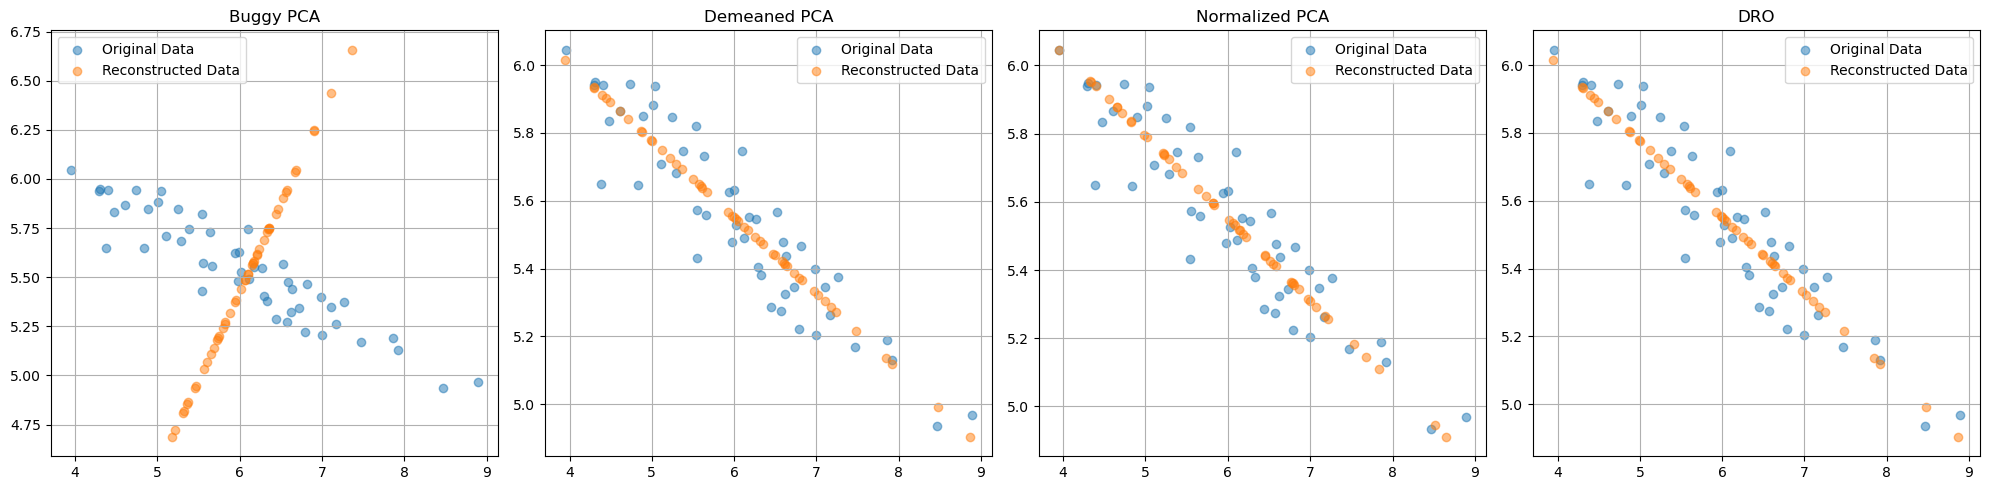

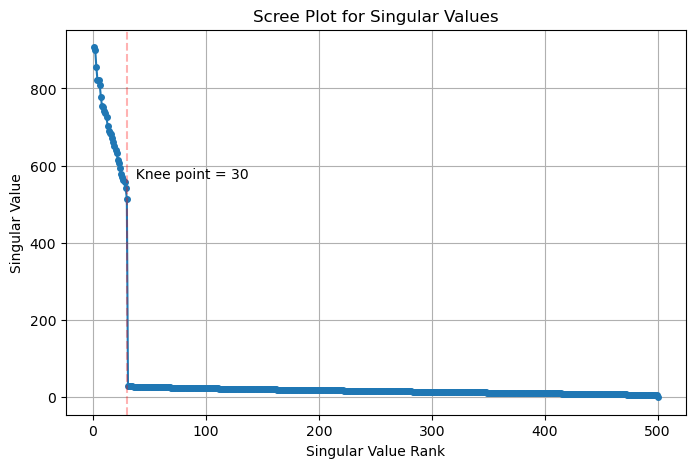

In [50]:
# Function to plot the original and reconstructed points for the 2D dataset
def plot_2d_reconstructions(original_data, reconstructions, titles, file_name='reconstruction_plot.png'):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, (recon, title) in enumerate(zip(reconstructions, titles)):
        axs[i].scatter(original_data[:, 0], original_data[:, 1], label='Original Data', alpha=0.5)
        axs[i].scatter(recon[:, 0], recon[:, 1], label='Reconstructed Data', alpha=0.5)
        axs[i].set_title(title)
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Call the function with the reconstructed points from each method
reconstructed_points = [recon_buggy, recon_demeaned, recon_normalized, recon_dro]
method_titles = ['Buggy PCA', 'Demeaned PCA', 'Normalized PCA', 'DRO']
plot_2d_reconstructions(data2D, reconstructed_points, method_titles)

# Function to plot the scree plot for the 1000D dataset
def plot_scree(S, file_name='scree_plot.png'):
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(S) + 1), S, 'o-', markersize=4)
    plt.title('Scree Plot for Singular Values')
    plt.xlabel('Singular Value Rank')
    plt.ylabel('Singular Value')
    
    # Add a vertical line and annotation for the knee point
    plt.axvline(x=knee_point, color='r', linestyle='--', alpha = 0.3)
    plt.annotate('  Knee point = 30', xy=(knee_point, S[knee_point-1]), 
                 xytext=(knee_point, S[knee_point-1]*1.1))
 
    plt.grid(True)
    plt.savefig(file_name)
    plt.show()

# Call the function with the singular values from SVD of the 1000D dataset
plot_scree(S)
